In [1]:
# HIDE CODE
from dateutil.relativedelta import relativedelta
from joblib import dump, load
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 12})


import warnings
import sys
import os
sys.path.append('/home/server/gli-data-science/')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import os
import ds_db
import helper_db
from helper import transform_to_rupiah, rupiah_format

import pickle
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import display, HTML, display_html, IFrame
import ipywidgets as ipyw

def side_by_side_display(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    styles = [
        dict(selector="caption", props=[("caption-side", "center"), ("font-size", "100%"), ("color", )])]
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline; font-size:85%' ").set_precision(2).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0"

    display(HTML(output))

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

import textwrap
def split_label(list_label):
    list_label = list(list_label)
    list_label = ["<br>".join(textwrap.wrap(t, width=12)) for t in list_label ]
    return list_label

### ide kasar
> 
* daily job to loop all member alfagift 10 juta
* compute feature trx voucher used, # of trx, # of sales
* compute feature event app site open / view product / atc
* updating each feature and re predict churn feature
* lets play in month - 3 for each define trx and event feature

In [2]:
pv1 = pd.read_csv('./pv_01Sep21.csv')
pv2 = pd.read_csv('./pv_01Oct21.csv')
pv3 = pd.read_csv('./pv_01Aug21.csv')

df_pv = pv1.merge(pv2, on='TRO_MEMBERS', how='outer').merge(pv3, on='TRO_MEMBERS', how='outer').rename(
                                columns={'COUNT_VIEW_PRODUCT_x':'PV_2021-09',
                                        'COUNT_VIEW_PRODUCT_y':'PV_2021-10',
                                        'COUNT_VIEW_PRODUCT':'PV_2021-08'})


In [3]:
df_pv.head()

,TRO_MEMBERS,PV_2021-09,PV_2021-10,PV_2021-08
0,9990010021450334,21.0,11.0,NaN
1,9990010021508161,67.0,50.0,110.0
2,9990010021520295,5.0,8.0,NaN
3,9990010021521900,71.0,50.0,14.0
4,9990010021526743,2.0,1.0,4.0


In [4]:
from datetime import datetime
now = datetime.now()
now_ = datetime(now.year, now.month, now.day)
## 9990010000070044
# sample with minus

q = '''

select 
    ttdr.tbtdr_created_date, 
    ttdr.tbtdr_ponta_user AS TRO_MEMBERS, 
    ttdr.tbtdr_tbto_id, 
    ttdr.tbtdr_rating AS rating
from 
    tb_transaction_delivery_rating ttdr 
where 
    ttdr.tbtdr_created_date between '2021-08-01' and '2021-12-01'
    and ttdr.tbtdr_rating > 0
'''.format(now_)

con, cur = ds_db.connect_prd_order_4()
df_re = pd.read_sql(q, con)


con.close()

df_re['created_date'] = df_re['tbtdr_created_date'].dt.strftime('%Y-%m')
df_re = df_re[df_re['tro_members'] != '']

## groupby and get feature by rating below good and rating avg
df_re_g = df_re.groupby(['tro_members', 'created_date']).agg(
                                rating_below = ('rating', lambda x: len(x[x<3])),
                                rating_avg = ('rating','mean')
                            )
df_re_g_u = df_re_g.unstack(level=1).fillna(0).reset_index()
df_re_g_u.columns = [' '.join(col).strip().upper() for col in df_re_g_u.columns.values]

df_re_g_u.head(20)

You are connected


,TRO_MEMBERS,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,9990010000069277,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
1,9990010000070044,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,9990010000089999,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,9990010000152057,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
4,9990010000191790,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
5,9990010000196641,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0
6,9990010000198083,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
7,9990010000199110,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
8,9990010000206060,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
9,9990010000208214,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0


In [5]:
df_re['tbtdr_created_date'].min(), df_re['tbtdr_created_date'].max()

(Timestamp('2021-08-01 00:06:13.492000'),
 Timestamp('2021-11-30 23:51:16.002000'))

In [6]:
# HIDE CODE

## USING ORDER
import glob

df_tto = []
for end_date in pd.date_range('2021-07-01', '2022-01-01', freq='M'):
    start_date = end_date.replace(day=1)
    end_date_save = start_date + relativedelta(months=1)
    
    start_date_str = start_date.strftime('%d%b%y')
    end_date_str = end_date_save.strftime('%d%b%y')
    
    print(start_date_str, end_date_str)
    
    pf = '/home/server/gli-data-science/data/trans_oshop/{}_{}.csv'.format(start_date_str, end_date_str)
    df_tto.append(pd.read_csv(pf, sep='\t', dtype='object'))
    
df_tto = pd.concat(df_tto)

df_tto = df_tto[df_tto['TRO_MEMBERS'] != 'N']
df_tto['TRO_DATE'] = pd.to_datetime(df_tto['TRO_DATE'])
df_tto['TRO_NET'] = df_tto['TRO_NET'].astype('float', errors='ignore').astype('int', errors='ignore')


df_tto['TRO_QTY'] = df_tto['TRO_QTY'].astype(int)

01Jul21 01Aug21
01Aug21 01Sep21
01Sep21 01Oct21
01Oct21 01Nov21
01Nov21 01Dec21
01Dec21 01Jan22


In [7]:
df_tto['TRO_VOUCHER_USAGE'] = df_tto['TRO_VOUCHER_USAGE'].astype('float', errors='ignore').astype('int', errors='ignore')
df_tto['TRO_DATE_MONTH'] = df_tto['TRO_DATE'].dt.strftime('%Y-%m')


In [8]:
df_tto_sel = df_tto[(df_tto['TRO_DATE'] >= '2021-08-01') \
            & (df_tto['TRO_DATE'] <= '2021-11-30')]

In [9]:
df_sla = pd.read_csv('./sla_01Dec21.csv')
df_sla['ATT_SEND_DATE_TOSTORE'] = pd.to_datetime(df_sla['ATT_SEND_DATE_TOSTORE'])
df_sla['SLA'] = np.where(df_sla['SLA_NORM']< 0, 20, df_sla['SLA_NORM'])

In [10]:
df_tto_sel = pd.merge(df_tto_sel, df_sla, left_on='TRO_NO_ORDER', right_on='ATT_ORDER_ID', how='left')
df_tto_sel = df_tto_sel.drop(['ATT_ORDER_ID','ATT_ORDER_DATE','ATT_DELIVERY_DATE','ATT_SEND_DATE_TOSTORE','SLA_NORM'],1)

In [11]:
df_tto_sel['SLA'] = df_tto_sel['SLA'].fillna(20)
df_tto_sel['SLA_LATE'] = np.where(df_tto_sel['SLA'] > 60, 1,0)

In [12]:
df_tto_sel[df_tto_sel['SLA'].notnull()].head()

,TRO_DATE,TRO_CART_ID,TRO_KD_STORE,TRO_BRANCH_CODE,BRANCH_CODE,TRO_MEMBERS,TRO_NO_ORDER,TRO_PLU,TRO_QTY,TRO_VOUCHER_USAGE,TRO_PAYMENT_METHOD,TRO_NET,TRO_SHIP_METHOD,TRO_STATUS_SAPA,TRO_STATUS_RETUR,TRO_DATE_MONTH,SLA,SLA_LATE
0,2021-08-04,9310011,M705,YZ01,YZ01,9990012547663800,O-210804-AGPFMFQ,117289,1,0.0,sat-cod,31818,1,Y,N,2021-08,2.9,0
1,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,103001,2,0.0,sat-cod,363,1,Y,N,2021-08,3.2,0
2,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,414212,6,0.0,sat-cod,77454,1,Y,N,2021-08,3.2,0
3,2021-08-04,9311223,M705,YZ01,YZ01,9990012491276437,O-210804-AGFMMMR,421482,1,0.0,sat-cod,6818,1,Y,N,2021-08,3.2,0
4,2021-08-04,9314127,M705,YZ01,YZ01,9990013368444667,O-210804-AGJPFDV,103001,2,0.0,shopeepay,363,0,Y,N,2021-08,100.7,1


In [13]:
df_tto_sel_g = df_tto_sel.groupby(['TRO_MEMBERS','TRO_DATE_MONTH','TRO_NO_ORDER'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'nunique',
                              'SLA':'first',
                              'SLA_LATE':'first'
                             })
df_tto_sel_g = df_tto_sel_g.groupby(['TRO_MEMBERS','TRO_DATE_MONTH'])\
                        .agg({'TRO_NET':'sum',
                              'TRO_NO_ORDER':'sum',
                              'SLA':'sum',
                              'SLA_LATE':'sum'
                             })

In [14]:
df_tto_sel_g_u = df_tto_sel_g.unstack(level=1).fillna(0).reset_index()
df_tto_sel_g_u.columns = [' '.join(col).strip().upper() for col in df_tto_sel_g_u.columns.values]

In [15]:
df_tto_re = pd.merge(df_tto_sel_g_u, df_re_g_u, on='TRO_MEMBERS', how='left').fillna(0)

In [16]:
df_tto_re.head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,15.0,20.0,35.0,49.0,905.4,217.1,480.8,630.1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9990010000001771,82453.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000001999,86132.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_pv['TRO_MEMBERS'] = df_pv['TRO_MEMBERS'].astype(str)
df_tto_re_pv = pd.merge(df_tto_re, df_pv, on='TRO_MEMBERS', how='left').fillna(0)

In [18]:
df_tto_re_pv.head()

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08
0,006506519712,0.0,0.0,0.0,50362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9990010000001200,1789791.0,1791590.0,2412654.0,3117811.0,15.0,20.0,35.0,49.0,905.4,217.1,480.8,630.1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,22.0
2,9990010000001771,82453.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9990010000001999,86132.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,9990010000004582,0.0,0.0,191267.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9951.7,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0


In [19]:
# # condition_2_3 = (
# # ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-12'] == 0)) | \
    
# # ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-11'] == 0) & \
# # (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# # ((df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-10'] == 0) & \
# # (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-12'] == 0)) |
    
# # ((df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# # (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-11'] > 0) & \
# # (df_tto_re_pv['TRO_NET 2021-12'] == 0))
# # )

# # df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)



# condition_2_3 = (
# ((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] == 0)) | \
    
# ((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] == 0)) |
    
# ((df_tto_re_pv['TRO_NET 2021-08'] == 0) & \
# (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
# (df_tto_re_pv['TRO_NET 2021-11'] == 0))
# )

# df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

In [20]:
condition = ( 
          (df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

In [21]:
df_tto_re_pv['NET_10-09'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-09']
df_tto_re_pv['NET_09-08'] = df_tto_re_pv['TRO_NET 2021-09'] - df_tto_re_pv['TRO_NET 2021-08']
df_tto_re_pv['NET_10-08'] = df_tto_re_pv['TRO_NET 2021-10'] - df_tto_re_pv['TRO_NET 2021-08']

df_tto_re_pv['STRUK_10-09'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-09']
df_tto_re_pv['STRUK_09-08'] = df_tto_re_pv['TRO_NO_ORDER 2021-09'] - df_tto_re_pv['TRO_NO_ORDER 2021-08']
df_tto_re_pv['STRUK_10-08'] = df_tto_re_pv['TRO_NO_ORDER 2021-10'] - df_tto_re_pv['TRO_NO_ORDER 2021-08']

In [22]:
# print(df_ins[df_ins['label'] == 1]['NET_11-10'].median())
# print(df_ins[df_ins['label'] == 1]['NET_10-09'].median())
# print(df_ins[df_ins['label'] == 1]['NET_11-09'].median())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-10'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_10-09'].mean())
# print(df_ins[df_ins['label'] == 1]['STRUK_11-09'].mean())

In [23]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']

In [24]:
# clf_ridge = RidgeClassifier() 
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
# clf_ridge = LogisticRegression()  
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [26]:
# clf_ridge = DecisionTreeClassifier(random_state=0, max_depth=15) 
# clf_ridge.fit(X_train, y_train) 
# pred = clf_ridge.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)
# # from sklearn.tree import export_text
# # r = export_text(clf_ridge, feature_names=list(X_train), decimals=0, spacing=6)
# # print("prediction rule \n{}".format(r))

In [ ]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-08'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)

### RANDOM FOREST MODEL

### not oversampling version with threshold

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    155795
           1       0.62      0.18      0.28     14735

    accuracy                           0.92    170530
   macro avg       0.78      0.58      0.62    170530
weighted avg       0.90      0.92      0.90    170530



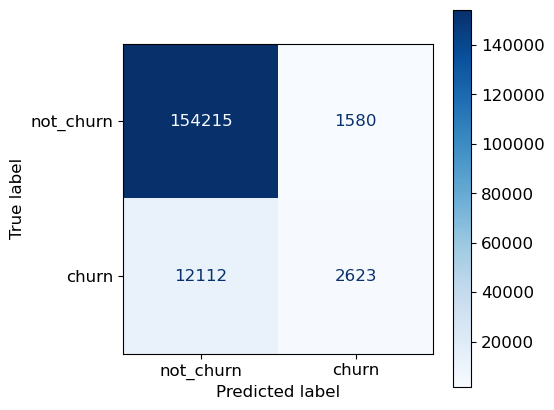

In [50]:
condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-08'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)





scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] > 0.6).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [51]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
10,9990013037642360,0.0,54361.0,210544.0,468084.0,0.0,1.0,1.0,3.0,0.0,2.0,23.9,128.4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0,2.0,156183.0,54361.0,210544.0,0.0,1.0,1.0,1,0
49,9990013073783912,89453.0,131088.0,8909.0,65271.0,2.0,1.0,1.0,2.0,766.5,30.0,2367.2,132.9,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,5.0,-122179.0,41635.0,-80544.0,0.0,-1.0,-1.0,1,0
62,9990013093006768,0.0,125634.0,62635.0,142178.0,0.0,2.0,1.0,1.0,0.0,142.0,62.2,1854.8,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,-62999.0,125634.0,62635.0,-1.0,2.0,1.0,1,0
90,9990011556744100,182361.0,0.0,200907.0,391807.0,1.0,0.0,1.0,2.0,205.3,0.0,28.5,43.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,7.0,200907.0,-182361.0,18546.0,1.0,-1.0,0.0,1,0
94,9990013406180550,0.0,296452.0,174271.0,245359.0,0.0,1.0,1.0,2.0,0.0,50.9,24.9,101.9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-122181.0,296452.0,174271.0,0.0,1.0,1.0,1,0
95,9990010506674760,0.0,1834780.0,274639.0,179178.0,0.0,12.0,2.0,2.0,0.0,9147.7,40.0,20.7,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,110.0,34.0,0.0,-1560141.0,1834780.0,274639.0,-10.0,12.0,2.0,1,0
179,9990013383292291,59999.0,0.0,57226.0,118088.0,1.0,0.0,1.0,2.0,8.5,0.0,16.4,10.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57226.0,-59999.0,-2773.0,1.0,-1.0,0.0,1,0
237,9990013390481623,421906.0,209949.0,156135.0,65453.0,5.0,4.0,1.0,1.0,7916.6,4605.4,1652.2,11.6,5.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-53814.0,-211957.0,-265771.0,-3.0,-1.0,-4.0,1,0
468,9990013417238752,0.0,259717.0,91087.0,163722.0,0.0,4.0,1.0,2.0,0.0,24.6,3.9,45.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-168630.0,259717.0,91087.0,-3.0,4.0,1.0,1,0
472,9990013268471998,93907.0,0.0,78271.0,474985.0,1.0,0.0,1.0,6.0,1531.2,0.0,15.0,1725.4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,78271.0,-93907.0,-15636.0,1.0,-1.0,0.0,1,0


In [52]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
3,9990013290475071,27363.0,43452.0,28635.0,0.0,1.0,2.0,1.0,0.0,2062.6,11382.8,1877.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14817.0,16089.0,1272.0,-1.0,1.0,0.0,0,1
6,9990012676929199,117817.0,0.0,567280.0,0.0,1.0,0.0,6.0,0.0,1917.6,0.0,7995.6,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,138.0,222.0,62.0,567280.0,-117817.0,449463.0,6.0,-1.0,5.0,0,1
15,9990012125101316,154542.0,444259.0,153174.0,0.0,1.0,4.0,1.0,0.0,15.7,140.6,15.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,10.0,10.0,-291085.0,289717.0,-1368.0,-3.0,3.0,0.0,0,1
21,9990011782081024,1512529.0,944986.0,612898.0,0.0,6.0,4.0,3.0,0.0,86.0,200.8,441.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,17.0,28.0,-332088.0,-567543.0,-899631.0,-1.0,-2.0,-3.0,0,1
28,9990010554265386,171542.0,0.0,230449.0,0.0,2.0,0.0,3.0,0.0,1723.2,0.0,5359.5,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,53.0,15.0,230449.0,-171542.0,58907.0,3.0,-2.0,1.0,0,1
36,9990013360443332,302350.0,500966.0,141088.0,0.0,6.0,11.0,2.0,0.0,52.1,67.0,18.5,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,5.0,1.6,0.0,0.0,24.0,14.0,0.0,-359878.0,198616.0,-161262.0,-9.0,5.0,-4.0,0,1
51,9990010550752700,297898.0,73178.0,111179.0,0.0,3.0,1.0,1.0,0.0,19.6,10.1,15.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,57.0,38001.0,-224720.0,-186719.0,0.0,-2.0,-2.0,0,1
85,9990013298194485,188635.0,201044.0,165635.0,0.0,2.0,3.0,2.0,0.0,40.3,58.9,45.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,11.0,5.0,-35409.0,12409.0,-23000.0,-1.0,1.0,0.0,0,1
87,9990010777053518,309271.0,0.0,127718.0,0.0,1.0,0.0,10.0,0.0,86.6,0.0,1378.8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,127718.0,-309271.0,-181553.0,10.0,-1.0,9.0,0,1
99,9990013300619456,1541091.0,430947.0,583088.0,0.0,23.0,8.0,11.0,0.0,237.7,80.5,230.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,152141.0,-1110144.0,-958003.0,3.0,-15.0,-12.0,0,1


In [68]:
X.head()

,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1789791.0,1791590.0,2412654.0,15.0,20.0,35.0,905.4,217.1,480.8,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,27.0,22.0,621064.0,1799.0,622863.0,15.0,5.0,20.0
2,82453.0,0.0,0.0,1.0,0.0,0.0,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-82453.0,-82453.0,0.0,-1.0,-1.0
3,86132.0,0.0,0.0,2.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-86132.0,-86132.0,0.0,-2.0,-2.0
4,0.0,0.0,191267.0,0.0,0.0,6.0,0.0,0.0,9951.7,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,191267.0,0.0,191267.0,6.0,0.0,6.0


### not oversampling version without threshold

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    164244
           1       0.53      0.12      0.19      6286

    accuracy                           0.96    170530
   macro avg       0.75      0.56      0.59    170530
weighted avg       0.95      0.96      0.95    170530



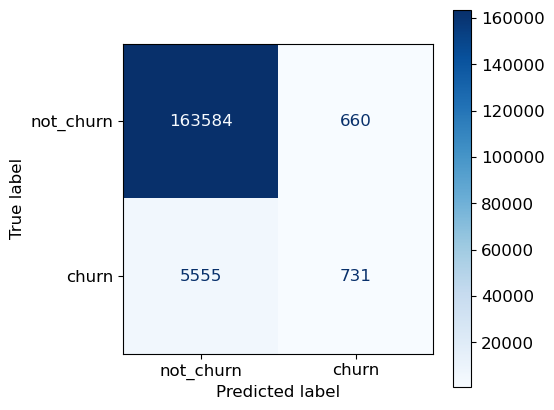

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43, stratify=y)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
# X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = RandomForestClassifier(random_state=42) 
clf_ridge.fit(X_train, y_train) 

pred = clf_ridge.predict(X_test)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [70]:
from sklearn import tree



text_representation = tree.export_text(clf_ridge.estimators_[0], feature_names=list(X))
print(text_representation)

|--- SLA 2021-08 <= 0.04
|   |--- class: 0.0
|--- SLA 2021-08 >  0.04
|   |--- TRO_NO_ORDER 2021-10 <= 0.50
|   |   |--- class: 0.0
|   |--- TRO_NO_ORDER 2021-10 >  0.50
|   |   |--- SLA 2021-09 <= 0.01
|   |   |   |--- PV_2021-10 <= 34.50
|   |   |   |   |--- SLA 2021-10 <= 3335.96
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- SLA 2021-10 >  3335.96
|   |   |   |   |   |--- SLA 2021-10 <= 3344.36
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- SLA 2021-10 >  3344.36
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- PV_2021-10 >  34.50
|   |   |   |   |--- RATING_AVG 2021-10 <= 4.90
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- RATING_AVG 2021-10 >  4.90
|   |   |   |   |   |--- NET_09-08 <= -736554.00
|   |   |   |   |   |   |--- RATING_AVG 2021-11 <= 2.50
|   |   |   |   |   |   |   |--- TRO_NET 2021-09 <= 37045.00
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- TRO_NET 2021-09 >  37045.00
|   |   |   |   

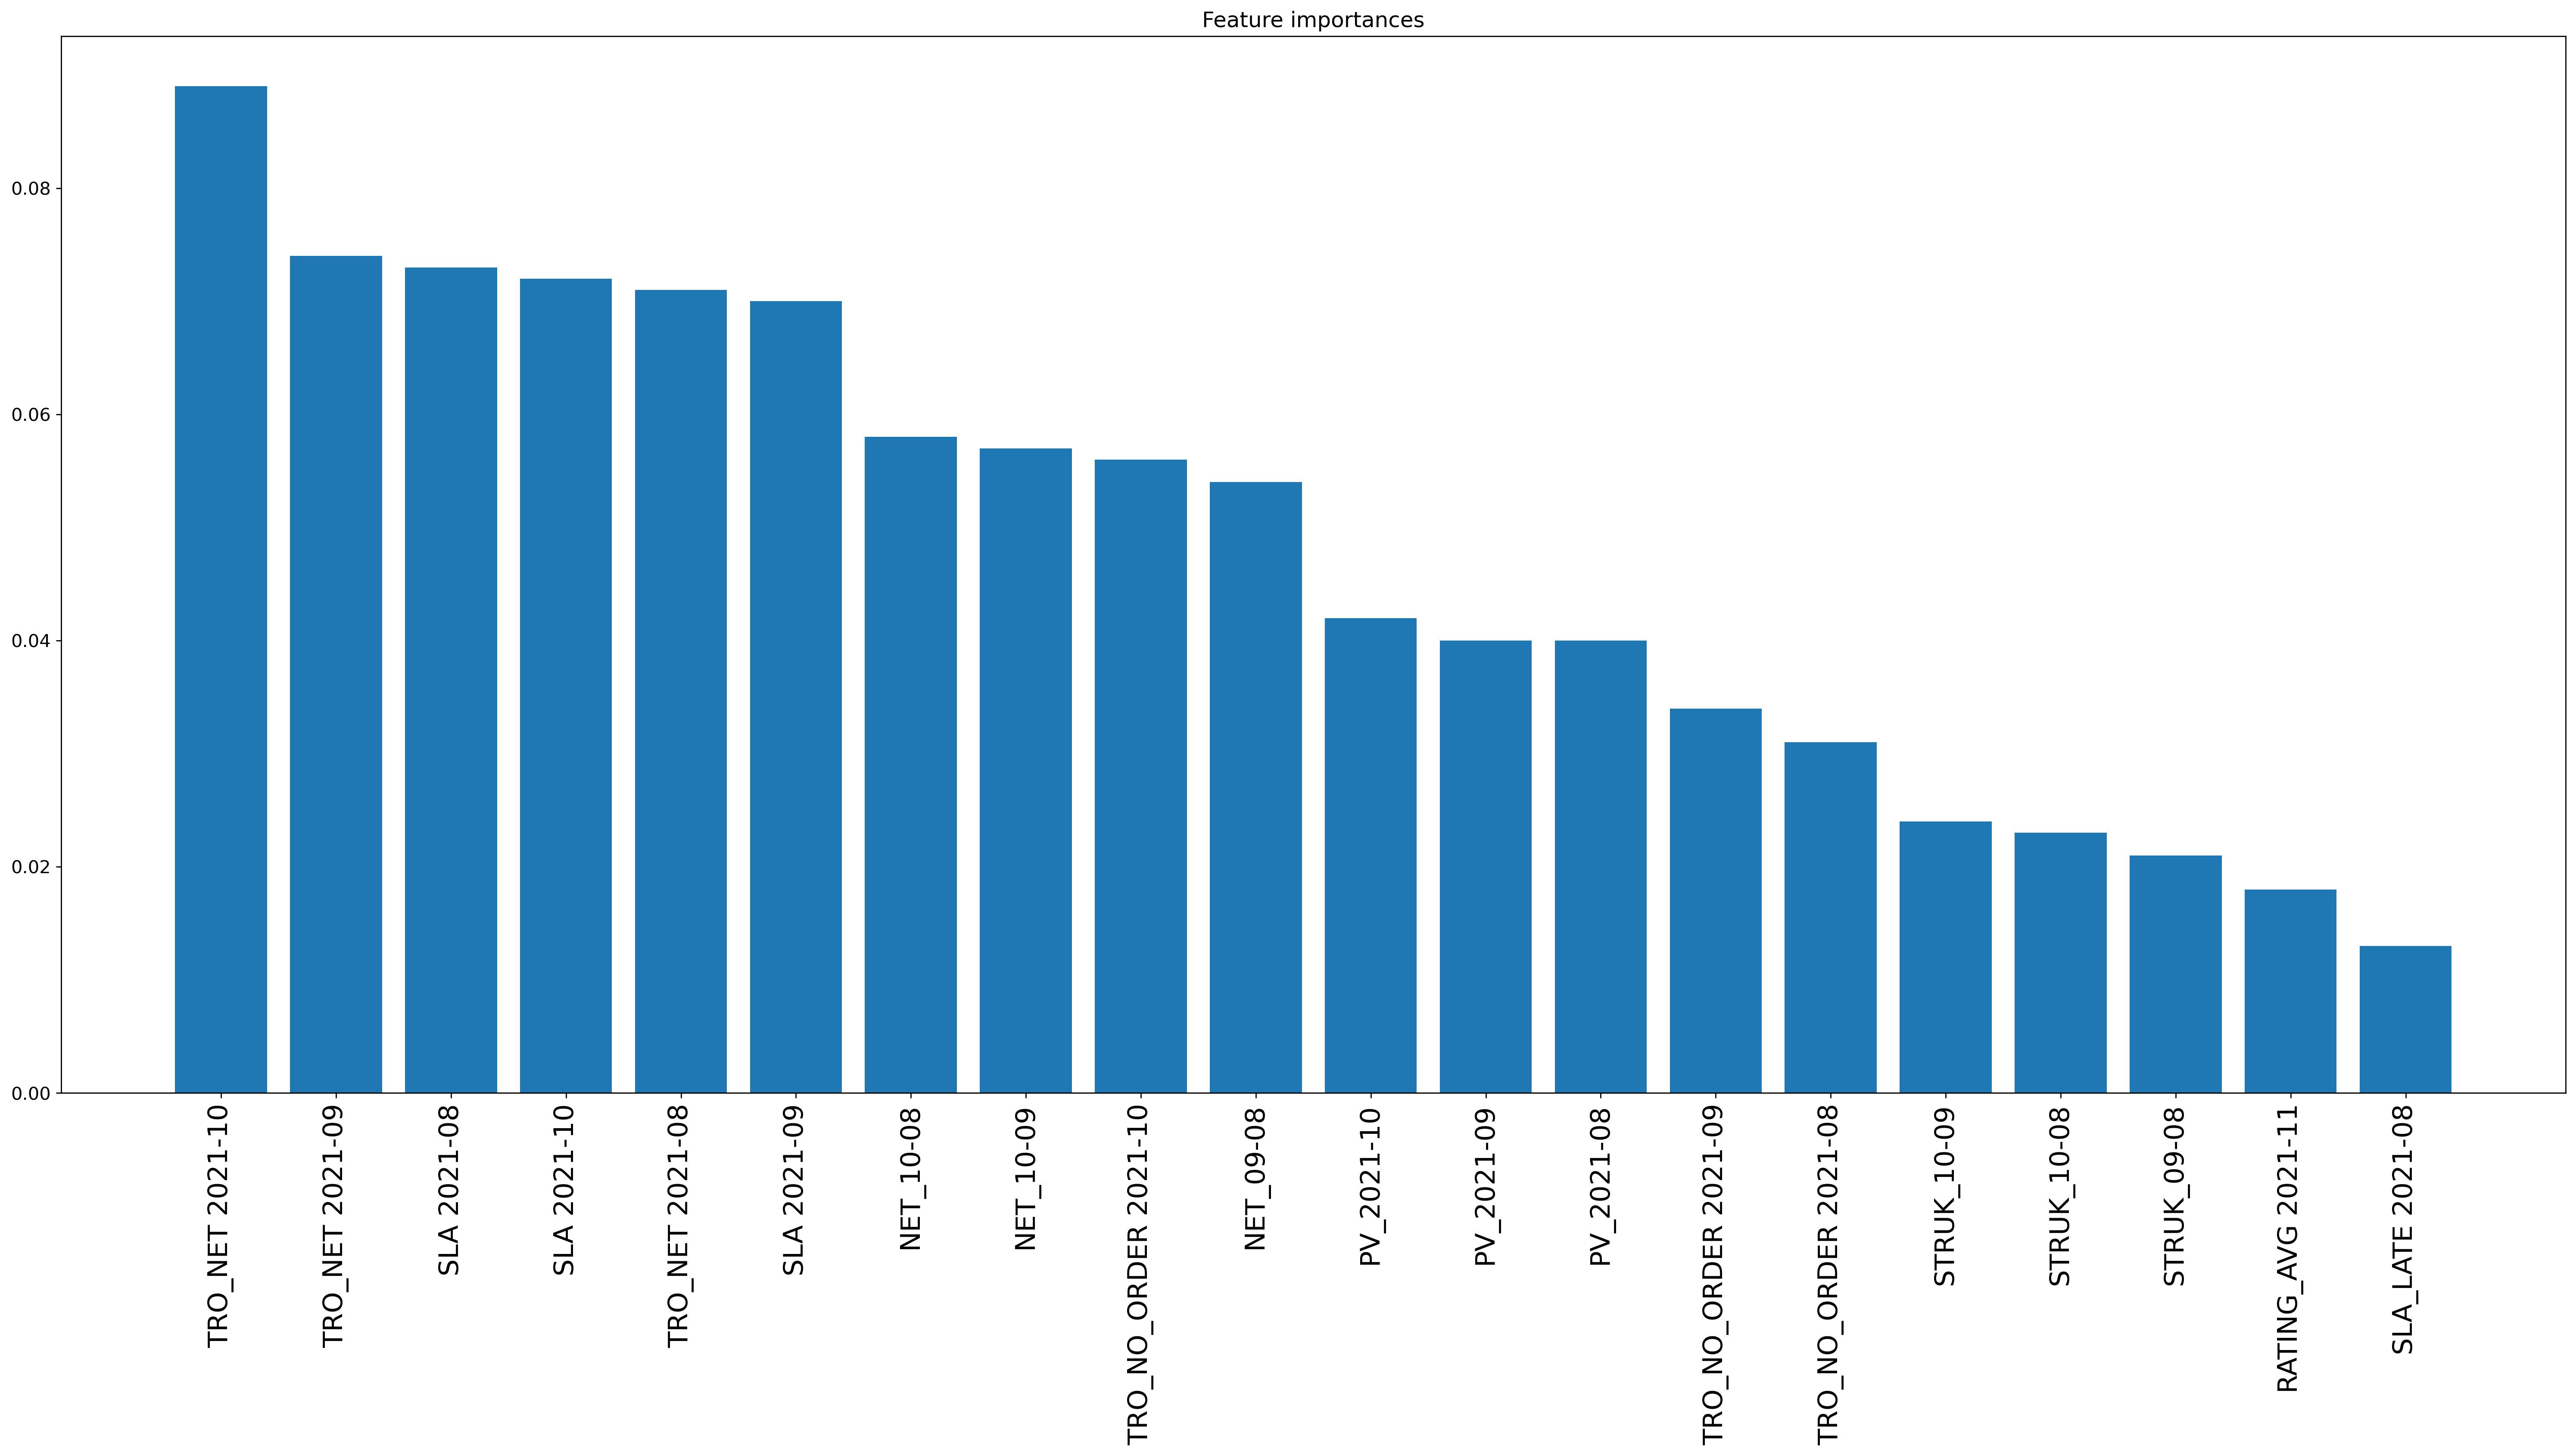

In [29]:
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(clf_ridge.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = importances[0:20]
x_range = list(range(importances.shape[0]))
x_plot = list(importances.index)
y_plot = list(importances["importance"])
plt.figure(figsize=(30,13), dpi=250)
plt.title("Feature importances")
plt.bar(x_range, y_plot)
plt.xticks(x_range, x_plot, rotation='vertical', fontsize=18)
fig = plt.gcf()


In [30]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [31]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
109,9990013302286591,592169.0,137271.0,114271.0,257684.0,8.0,1.0,1.0,3.0,153.2,20.0,1.5,86.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,19.0,11.0,-23000.0,-454898.0,-477898.0,0.0,-7.0,-7.0,1,0
251,9990011522547039,181177.0,40543.0,48815.0,222448.0,2.0,1.0,1.0,2.0,30.1,26.3,63.3,262.3,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,18.0,14.0,8272.0,-140634.0,-132362.0,0.0,-1.0,-1.0,1,0
376,9990013306258165,65725.0,57726.0,59270.0,237811.0,1.0,1.0,1.0,2.0,10.9,8.8,52.9,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,66.0,1544.0,-7999.0,-6455.0,0.0,0.0,0.0,1,0
531,9990013324290677,160677.0,42452.0,60087.0,57903.0,3.0,1.0,1.0,3.0,21.3,26.9,20.0,100.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,12.0,24.0,65.0,17635.0,-118225.0,-100590.0,0.0,-2.0,-2.0,1,0
546,9990013164786618,100271.0,51999.0,117180.0,34545.0,2.0,1.0,1.0,1.0,12.8,11.5,19.8,121.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,16.0,65181.0,-48272.0,16909.0,0.0,-1.0,-1.0,1,0
982,9990010509013853,847305.0,105271.0,83363.0,134087.0,5.0,1.0,1.0,1.0,1184.5,42.7,20.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25.0,-21908.0,-742034.0,-763942.0,0.0,-4.0,-4.0,1,0
1189,9990013179886118,221406.0,104444.0,98225.0,319266.0,1.0,1.0,1.0,3.0,106.5,1522.3,302.2,23.9,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,5.0,23.0,-6219.0,-116962.0,-123181.0,0.0,0.0,0.0,1,0
1555,9990013291649133,46362.0,68543.0,71179.0,82725.0,1.0,1.0,1.0,1.0,77.5,41.1,11.1,63.9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,2.0,2636.0,22181.0,24817.0,0.0,0.0,0.0,1,0
1759,9990010689755200,78179.0,91903.0,87452.0,281537.0,1.0,1.0,1.0,3.0,20.0,33.5,4.5,135.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,15.0,0.0,-4451.0,13724.0,9273.0,0.0,0.0,0.0,1,0
1843,9990011430369048,168269.0,83635.0,67817.0,170088.0,1.0,1.0,1.0,1.0,20.1,24.0,24.9,68.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,7.0,2.0,-15818.0,-84634.0,-100452.0,0.0,0.0,0.0,1,0


In [32]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
17,9990013372405453,380624.0,250718.0,199709.0,0.0,4.0,3.0,3.0,0.0,90.1,206.7,78.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,24.0,0.0,-51009.0,-129906.0,-180915.0,0.0,-1.0,-1.0,0,1
27,9990013354104637,54727.0,59636.0,29818.0,0.0,1.0,2.0,1.0,0.0,1832.5,4634.6,2021.5,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,-29818.0,4909.0,-24909.0,-1.0,1.0,0.0,0,1
79,9990013385125725,655352.0,735989.0,453631.0,0.0,5.0,4.0,3.0,0.0,130.2,96.2,23.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-282358.0,80637.0,-201721.0,-1.0,-1.0,-2.0,0,1
95,9990013277615315,390268.0,317720.0,252812.0,0.0,4.0,5.0,4.0,0.0,614.2,52.5,44.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,25.0,-64908.0,-72548.0,-137456.0,-1.0,1.0,0.0,0,1
138,9990013364770416,108725.0,88090.0,134479.0,0.0,2.0,1.0,2.0,0.0,118.3,20.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46389.0,-20635.0,25754.0,1.0,-1.0,0.0,0,1
146,9990013262112134,109633.0,14909.0,12681.0,0.0,4.0,1.0,1.0,0.0,7626.8,1816.2,1717.6,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,-2228.0,-94724.0,-96952.0,0.0,-3.0,-3.0,0,1
199,9990012069903056,288357.0,95226.0,89180.0,0.0,5.0,1.0,1.0,0.0,3390.3,1.4,20.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,9.0,-6046.0,-193131.0,-199177.0,0.0,-4.0,-4.0,0,1
208,9990013346382284,220361.0,111908.0,310354.0,0.0,2.0,1.0,4.0,0.0,24.2,7.1,660.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6.0,198446.0,-108453.0,89993.0,3.0,-1.0,2.0,0,1
224,9990013302529947,115812.0,410292.0,201086.0,0.0,3.0,4.0,2.0,0.0,31.5,70.2,29.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,6.0,122.0,-209206.0,294480.0,85274.0,-2.0,1.0,-1.0,0,1
228,9990013372434248,227901.0,328716.0,241082.0,0.0,2.0,3.0,2.0,0.0,41.2,91.9,78.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,0.0,-87634.0,100815.0,13181.0,-1.0,1.0,0.0,0,1


### oversampling version

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    164244
           1       0.39      0.46      0.42      6286

    accuracy                           0.95    170530
   macro avg       0.69      0.72      0.70    170530
weighted avg       0.96      0.95      0.96    170530



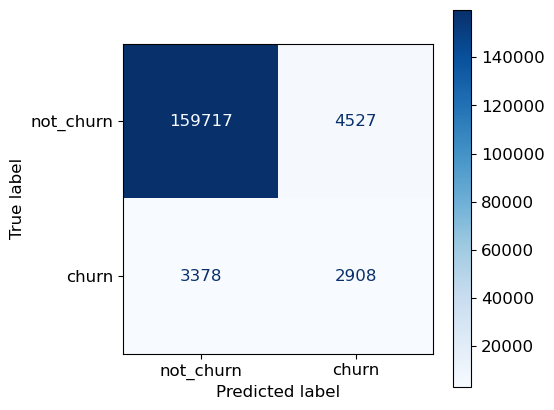

In [33]:
X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)


clf_ridge = RandomForestClassifier(n_jobs=32) 
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)
# pred = (clf_ridge.predict_proba(X_test)[:,1] > 0.8).astype(int)


print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [34]:
df_res = pd.concat([
    pd.concat([df_tto_re_pv.drop(['label'],1).loc[X_test.index, :].reset_index(drop=True), pd.DataFrame({'pred':pred})],1), 
    y_test.reset_index(drop=True)],1)

In [35]:
df_res[(df_res['label'] == 0) & (df_res['pred'] == 1)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
10,9990013055612080,169994.0,200172.0,121721.0,82178.0,2.0,3.0,1.0,1.0,1350.0,62.5,1526.0,52.7,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,10.0,12.0,-78451.0,30178.0,-48273.0,-2.0,1.0,-1.0,1,0
14,9990013383069110,388632.0,195088.0,94363.0,253816.0,5.0,3.0,2.0,2.0,779.4,43.1,11.2,31.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,-100725.0,-193544.0,-294269.0,-1.0,-2.0,-3.0,1,0
67,9990011984801400,294990.0,106180.0,94360.0,70726.0,3.0,1.0,1.0,1.0,104.7,7.8,20.0,50.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,4.0,6.0,-11820.0,-188810.0,-200630.0,0.0,-2.0,-2.0,1,0
72,9990010059119377,1232718.0,186360.0,216906.0,541719.0,4.0,1.0,1.0,3.0,1371.8,26.7,19.1,95.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,30546.0,-1046358.0,-1015812.0,0.0,-3.0,-3.0,1,0
96,9990010810890257,19545.0,21909.0,14090.0,83817.0,1.0,1.0,1.0,2.0,1951.2,1639.7,1645.0,3256.1,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,-7819.0,2364.0,-5455.0,0.0,0.0,0.0,1,0
129,9990013331571564,388533.0,238540.0,114543.0,479262.0,1.0,1.0,1.0,4.0,30.0,20.0,24.7,329.7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,9.0,-123997.0,-149993.0,-273990.0,0.0,0.0,0.0,1,0
149,9990013392285800,28909.0,365719.0,200545.0,331452.0,1.0,11.0,4.0,3.0,1825.9,20766.7,6315.4,4841.6,1.0,11.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-165174.0,336810.0,171636.0,-7.0,10.0,3.0,1,0
161,9990013316341296,91179.0,238519.0,98987.0,447459.0,1.0,3.0,1.0,3.0,20.0,69.5,20.0,71.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,-139532.0,147340.0,7808.0,-2.0,2.0,0.0,1,0
281,9990013354981340,239984.0,291539.0,767621.0,690217.0,1.0,1.0,2.0,2.0,13.7,26.1,17.8,34.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,476082.0,51555.0,527637.0,1.0,0.0,1.0,1,0
390,9990010031054000,37681.0,1351778.0,162541.0,81724.0,1.0,32.0,3.0,2.0,20.0,569.6,60.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,7.0,0.0,-1189237.0,1314097.0,124860.0,-29.0,31.0,2.0,1,0


In [36]:
df_res[(df_res['label'] == 1) & (df_res['pred'] == 0)].head(10)

,TRO_MEMBERS,TRO_NET 2021-08,TRO_NET 2021-09,TRO_NET 2021-10,TRO_NET 2021-11,TRO_NO_ORDER 2021-08,TRO_NO_ORDER 2021-09,TRO_NO_ORDER 2021-10,TRO_NO_ORDER 2021-11,SLA 2021-08,SLA 2021-09,SLA 2021-10,SLA 2021-11,SLA_LATE 2021-08,SLA_LATE 2021-09,SLA_LATE 2021-10,SLA_LATE 2021-11,RATING_BELOW 2021-08,RATING_BELOW 2021-09,RATING_BELOW 2021-10,RATING_BELOW 2021-11,RATING_AVG 2021-08,RATING_AVG 2021-09,RATING_AVG 2021-10,RATING_AVG 2021-11,PV_2021-09,PV_2021-10,PV_2021-08,NET_10-09,NET_09-08,NET_10-08,STRUK_10-09,STRUK_09-08,STRUK_10-08,pred,label
61,9990013258544200,5589158.0,8280237.0,2254447.0,0.0,79.0,117.0,41.0,0.0,631.9,579.9,481.1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,122.0,193.0,-6025790.0,2691079.0,-3334711.0,-76.0,38.0,-38.0,0,1
62,9990012533204400,258543.0,137589.0,460404.0,0.0,2.0,1.0,2.0,0.0,1597.4,25.8,16.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,6.0,322815.0,-120954.0,201861.0,1.0,-1.0,0.0,0,1
180,9990011869356744,135726.0,15090.0,205268.0,0.0,1.0,1.0,3.0,0.0,539.7,2911.2,8110.2,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,7.0,190178.0,-120636.0,69542.0,2.0,0.0,2.0,0,1
327,9990013330749544,30998.0,127449.0,154722.0,0.0,1.0,1.0,3.0,0.0,129.6,66.7,52.6,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,64.0,5.0,27273.0,96451.0,123724.0,2.0,0.0,2.0,0,1
337,9990013381841848,581272.0,436360.0,1091559.0,0.0,6.0,6.0,13.0,0.0,9896.9,10034.9,23680.2,0.0,6.0,6.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,655199.0,-144912.0,510287.0,7.0,0.0,7.0,0,1
358,9990012913450559,325435.0,125901.0,136903.0,0.0,5.0,2.0,2.0,0.0,85.4,27.2,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,26.0,27.0,11002.0,-199534.0,-188532.0,0.0,-3.0,-3.0,0,1
397,9990013398044764,622355.0,408586.0,283178.0,0.0,13.0,10.0,7.0,0.0,13382.4,13754.9,10460.4,0.0,7.0,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-125408.0,-213769.0,-339177.0,-3.0,-3.0,-6.0,0,1
510,9990013400112176,234901.0,441898.0,373353.0,0.0,1.0,2.0,2.0,0.0,20.0,40.2,36.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,-68545.0,206997.0,138452.0,0.0,1.0,1.0,0,1
573,9990013306885698,243166.0,91632.0,132539.0,0.0,3.0,2.0,3.0,0.0,40.1,19.6,37.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,46.0,40907.0,-151534.0,-110627.0,1.0,-1.0,0.0,0,1
613,9990010210264145,425984.0,119176.0,293714.0,0.0,5.0,2.0,4.0,0.0,104.8,41.8,88.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,15.0,52.0,174538.0,-306808.0,-132270.0,2.0,-3.0,-1.0,0,1


## USING XGBOOST

### oversampling version

[16:12:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.92      0.96    164244
           1       0.29      0.83      0.43      6286

    accuracy                           0.92    170530
   macro avg       0.64      0.88      0.69    170530
weighted avg       0.97      0.92      0.94    170530



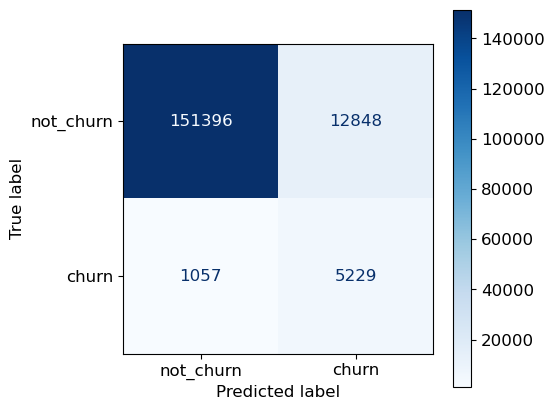

In [37]:
import xgboost as xgb 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train = oversampler.fit_resample(X_train, y_train)

clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')


### not oversampling version

[16:13:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      0.92      0.96    164244
           1       0.29      0.83      0.43      6286

    accuracy                           0.92    170530
   macro avg       0.64      0.88      0.69    170530
weighted avg       0.97      0.92      0.94    170530



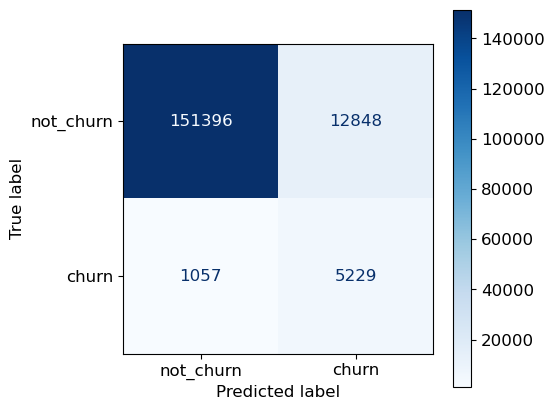

In [38]:
import xgboost as xgb 




scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1)
clf_ridge.fit(X_train, y_train) 
pred = clf_ridge.predict(X_test)

print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', 
                                        display_labels= ['not_churn', 'churn'], ax = ax, values_format = 'd')


## MLP 3/3 normal

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    164244
           1       0.56      0.04      0.08      6286

    accuracy                           0.96    170530
   macro avg       0.76      0.52      0.53    170530
weighted avg       0.95      0.96      0.95    170530



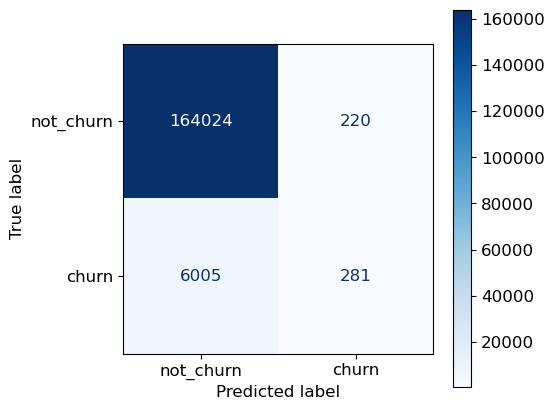

In [54]:
from sklearn.neural_network import MLPClassifier

condition = ( 
          (df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
          (df_tto_re_pv['TRO_NET 2021-11'] == 0) 
)
df_tto_re_pv['label'] = np.where(condition, 1, 0)

X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,))
clf_ridge.fit(X_train, y_train) 



# pred = clf_ridge.predict(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

## MLP 2/3 normal

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    155795
           1       0.60      0.18      0.28     14735

    accuracy                           0.92    170530
   macro avg       0.76      0.58      0.62    170530
weighted avg       0.90      0.92      0.90    170530



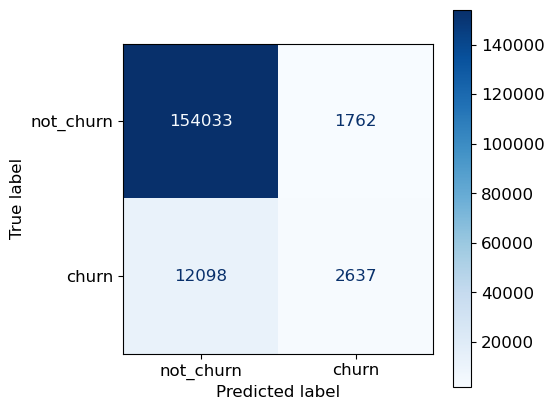

In [55]:
from sklearn.neural_network import MLPClassifier

condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) | \
    
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)) |
    
((df_tto_re_pv['TRO_NET 2021-08'] == 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0))
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)



scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

clf_ridge = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(30,)) 
clf_ridge.fit(X_train, y_train) 
# pred_proba = clf_ridge.predict_proba(X_test)
pred = (clf_ridge.predict_proba(X_test)[:,1] >= 0.5).astype(int)
print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

## simple ruling ( construct own rule )

              precision    recall  f1-score   support

           0       0.97      0.93      0.95    164244
           1       0.12      0.24      0.16      6286

    accuracy                           0.91    170530
   macro avg       0.55      0.59      0.56    170530
weighted avg       0.94      0.91      0.92    170530



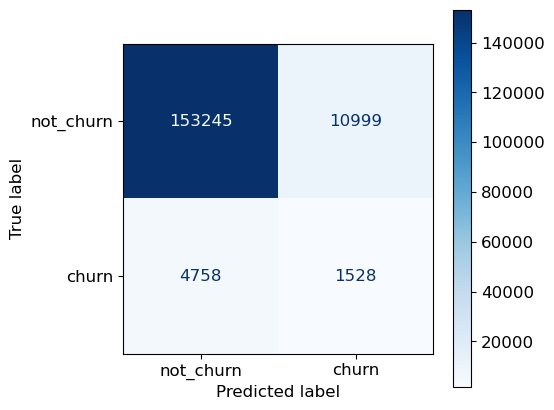

In [61]:

condition_2_3 = (
((df_tto_re_pv['TRO_NET 2021-08'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-09'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-10'] > 0) & \
(df_tto_re_pv['TRO_NET 2021-11'] == 0)
)
)

df_tto_re_pv['label'] = np.where(condition_2_3, 1, 0)


X = df_tto_re_pv.drop(
[
'TRO_MEMBERS',
'TRO_NET 2021-11', 
'TRO_NO_ORDER 2021-11',
'SLA 2021-11',
'SLA_LATE 2021-11',
'label'
], 1
)
y = df_tto_re_pv['label']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

condition_2_3 = (
((X_test['NET_10-09'] < 0) & \
(X_test['NET_09-08'] < 0) & \
(X_test['NET_10-08'] < 0)
)
)

pred = np.where(condition_2_3, 1, 0)




print(classification_report(y_test, pred))
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ConfusionMatrixDisplay.from_predictions(y_test, pred, 
                                        cmap='Blues', display_labels= ['not_churn', 'churn'], 
                                        ax = ax, values_format = 'd')

In [40]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
# def randomForest_fit(x_train, y_train, scoring = 'f1_macro'):
#     randomForest = RandomForestClassifier(random_state=123)

#     hyperparam = {'min_samples_leaf': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
#                   'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75], 
#                   'n_estimators': [100, 200, 300, 500, 750, 1000]}
    
# #     random_randomForest = RandomizedSearchCV(randomForest, param_distributions = hyperparam, cv = 5, 
# #                                            n_iter = 6, scoring = scoring, n_jobs=-1, random_state = 123) 
# #     to long running time
#     random_randomForest = GridSearchCV(randomForest, param_grid = hyperparam, cv = 5, 
#                                         scoring = scoring, n_jobs=32)
#     random_randomForest.fit(x_train, y_train)
    
#     print ("Best F1", random_randomForest.best_score_)
#     print ("Best Param", random_randomForest.best_params_)
#     return random_randomForest

# best_randForest = randomForest_fit(X, y)

In [41]:
# randForest = RandomForestClassifier(random_state=123, n_jobs = -1,
#                                    min_samples_leaf = best_randForest.best_params_.get('min_samples_leaf'),
#                                    max_features = best_randForest.best_params_.get('max_features'),
#                                    n_estimators = best_randForest.best_params_.get('n_estimators'))
# name = randForest.__class__.__name__
# randForest.fit(X_train, y_train) 
# pred = randForest.predict(X_test)

# print(classification_report(y_test, pred))
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# plot_confusion_matrix(clf_ridge, X_test, y_test, cmap='Blues', display_labels= ['not_churn', 'churn'], ax = ax)

In [42]:
# coba cek master member
# join dengan member id yang 8 angka
# cari create date dengan member yang terbaru

In [43]:
# import cx_Oracle
# from sqlalchemy import event,create_engine,types

# driver = 'cx_oracle'
# server = '10.234.152.61' 
# database = 'alfabi' 
# username = 'report' 
# password = 'justd0it'
# engine_stmt = "oracle://%s:%s@%s/%s" % (username, password, server, database )

# engine = create_engine(engine_stmt)

# df = df_tto_re[['TRO_MEMBERS']]
# dtyp = {c:types.VARCHAR(df[c].str.len().max()) for c in df.columns[df.dtypes == 'object'].tolist()}
# df.to_sql('temp_churn', engine, index=False, if_exists="replace", dtype=dtyp)

# engine.dispose()

In [44]:
# li_df_pv = []

# for dr in pd.date_range('2021-11-01', '2021-11-30'):
#     df_f = dr.strftime('%d-%b-%y')
#     q = '''
#     SELECT 
#         tc.TRO_MEMBERS, 
#         count(ame.AME_CART_PRODUCT_ID) AS COUNT_VIEW_PRODUCT
#     FROM 
#         TEMP_CHURN tc
#         LEFT JOIN PLMS_MEMBER_PROFILE pmp 
#         ON pmp.PMP_MEMBER_ID = tc.TRO_MEMBERS 
#         LEFT JOIN ALFAGIFT_MOE_EVENTS ame 
#         ON ame.AME_PONTA_ID = pmp.PMP_MEMBER_UNIQUE_ID 
#         LEFT JOIN ALFAGIFT_MASTER_PRODUCT amp 
#         ON amp.PRODUCT_ID = ame.AME_CART_PRODUCT_ID 
#     WHERE 
#         TRUNC(ame.AME_EVENT_TIME) BETWEEN '{}' AND '{}'
#         AND ame.AME_EVENT_NAME = 'view_product'
#     GROUP BY tc.TRO_MEMBERS

#     '''.format(df_f, df_f)
#     con = ds_db.connect_alfabi()
#     df_pv = pd.read_sql_query(q, con)
#     con.close()
#     li_df_pv.append(df_pv)
    
# df_pv.head(20)